## Upload datasets

In [33]:
import pandas as pd
import numpy as np
train_dataset = pd.read_csv('train.csv')
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)
predict_dataset = pd.read_csv('test.csv')

train_dataset

,id,keyword,location,text,target
0,6059,heat%20wave,"Frisco, TX",@wfaaweather Pete when will the heat wave pass...,1
1,5065,famine,NaN,Hunger hits me and I can't function probably w...,0
2,10457,wild%20fires,"Los Angeles, CA",@SenFeinstein Thanks Sen. Feinstein now hurr...,1
3,6893,mass%20murder,"Birmingham, England",#DebateQuestionsWeWantToHear Why does #Saudi a...,1
4,7603,pandemonium,Scotland,@J3Lyon I'm going to put the FFVII ones out at...,0
...,...,...,...,...,...
7608,9018,stretcher,NaN,Sweater Stretcher http://t.co/naTz5iPV1x http:...,0
7609,6145,hijack,NaN,0-day bug in fully patched OS X comes under ac...,0
7610,7566,outbreak,Canada,DTN Italy: Families to sue over Legionnaires: ...,1
7611,3737,destroyed,NaN,@DavidVitter Hi David in 2003 I saw the USA wa...,1


In [34]:
train_dataset.count()
#The dataset (train and test) has 10876 lines, 7613 have the variable "target" (train) and 3263 are test data
#The variable keyword gives the theme of the tweet, it allows to categorize tweets, it is missing in some instances
#Text is the tweet, they are all in English, they contain many special characters that need to be removed
#Location is missing on a majority of instance

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [35]:
train_dataset.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# Treatment of the "text" variable


In [36]:
#Extracting hashtags
import re
def extract_hashtags(dataset):
    hashtags = dataset['text'].str.extractall(r'#([A-Za-z0-9]+)')
    hashtags.index = hashtags.index.get_level_values(0)
    hashtags = hashtags.groupby([hashtags.index]).agg(lambda col: list(col))
    hashtags = hashtags.rename(columns={0:'hashtags'})
    dataset = dataset.merge(hashtags, how='left', left_index=True, right_index=True)
    return dataset

train_dataset = extract_hashtags(train_dataset)
predict_dataset = extract_hashtags(predict_dataset)

In [37]:
def normalize_text(string):
    string = string.lower()
    string = re.sub('http[\S]+', '', string)
    string = re.sub('[^\w\s]','', string)
    string = re.sub('[0-9]+', '', string)
    return string

In [38]:
train_dataset['text'] = train_dataset['text'].apply(lambda string : normalize_text(string))
predict_dataset['text'] = predict_dataset['text'].apply(lambda string : normalize_text(string))

# Tfidf vectorization and simple NN

In [39]:
#Spacy tokenization + Lemmatization + removing stop words

In [40]:
import spacy
nlp = spacy.load('en_core_web_md')
stop_words = nlp.Defaults.stop_words

def tokenize(string):
    tokens = nlp(string)
    tokens_nostop = ''
    for token in tokens:
        if token.text not in stop_words:
            tokens_nostop = tokens_nostop + ' ' + token.lemma_
    return tokens_nostop

In [41]:
train_dataset['text'] = train_dataset['text'].apply(lambda text: tokenize(text))
predict_dataset['text'] = predict_dataset['text'].apply(lambda text: tokenize(text))

In [42]:
# TfIdf Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=2)
tfidf_vectorizer.fit(train_dataset['text'])

train_dataset_X = tfidf_vectorizer.transform(train_dataset['text']).toarray()
predict_dataset_X = tfidf_vectorizer.transform(predict_dataset['text']).toarray()

#y
train_dataset_y = np.array(train_dataset['target'])

In [43]:
#Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_dataset_X, train_dataset_y, test_size=0.33, random_state=42)

# Logistic regression

In [13]:
#Model: simple logistic regression on tfidf features
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_test_predicted = classifier.predict(X_test)

C:\Users\jean_\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
#Performance metrics
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_test, y_test_predicted)
print('Accuracy is: '+ str(100*accuracy)+'%')

Accuracy is: 80.4615996816554%


In [15]:
confusion_matrix(y_test, y_test_predicted)

array([[1289,  124],
       [ 367,  733]], dtype=int64)

In [16]:
predict_dataset_predict_y = classifier.predict(predict_dataset_X)

In [17]:
prediction_df = pd.DataFrame(predict_dataset_predict_y, columns=['target'])

In [18]:
prediction_df = prediction_df.merge(predict_dataset[['id']], left_index=True, right_index=True)

In [19]:
prediction_df = prediction_df[['id','target']]
prediction_df.to_csv('submission1.csv', index=False)

In [20]:
#This submission got a result of 80.46% on Kaggle

# Neural network for classification

In [47]:
#Neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

from keras.optimizers import SGD
from keras.optimizers import Adam

model_nn = Sequential()
model_nn.add(Dense(300, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.0001)))

model_nn.add(Dense(300, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))

model_nn.add(Dense(1, activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [48]:
#Train model
training_process = model_nn.fit(X_train, y_train, epochs=7, validation_data=(X_test, y_test))

Train on 5100 samples, validate on 2513 samples
Epoch 1/7
5100/5100 [==============================] - 5s 1ms/step - loss: 2.6793 - accuracy: 0.5684 - val_loss: 1.8024 - val_accuracy: 0.5702
Epoch 2/7
5100/5100 [==============================] - 5s 969us/step - loss: 1.3052 - accuracy: 0.5751 - val_loss: 0.9784 - val_accuracy: 0.6140
Epoch 3/7
5100/5100 [==============================] - 5s 1ms/step - loss: 0.8852 - accuracy: 0.6582 - val_loss: 0.8234 - val_accuracy: 0.7660
Epoch 4/7
5100/5100 [==============================] - 6s 1ms/step - loss: 0.7603 - accuracy: 0.7704 - val_loss: 0.7235 - val_accuracy: 0.7887
Epoch 5/7
5100/5100 [==============================] - 7s 1ms/step - loss: 0.6671 - accuracy: 0.8124 - val_loss: 0.6647 - val_accuracy: 0.7895
Epoch 6/7
5100/5100 [==============================] - 6s 1ms/step - loss: 0.6046 - accuracy: 0.8333 - val_loss: 0.6337 - val_accuracy: 0.7891
Epoch 7/7
5100/5100 [==============================] - 7s 1ms/step - loss: 0.5657 - accuracy

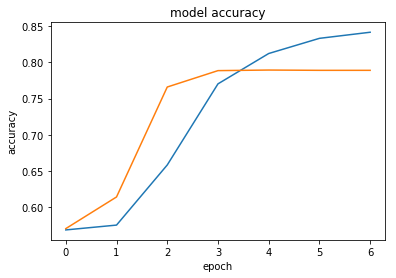

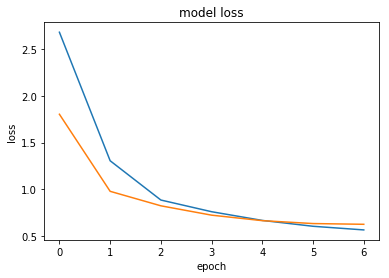

In [50]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(training_process.history['accuracy'])
plt.plot(training_process.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(training_process.history['loss'])
plt.plot(training_process.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [51]:
from sklearn.metrics import accuracy_score
y_test_predicted = model_nn.predict(X_test)
y_test_predicted = np.where(y_test_predicted >= 0.5, 1, y_test_predicted)
y_test_predicted = np.where(y_test_predicted < 0.5, 0, y_test_predicted)
accuracy = accuracy_score(y_test, y_test_predicted)
print('Accuracy is: '+ str(100*accuracy)+'%')

Accuracy is: 78.90966971746916%


## RNN network

In [71]:
# Fit keras tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(train_dataset['text'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14734 unique tokens.


In [72]:
#X variable
X_train_dataset = tokenizer.texts_to_sequences(train_dataset['text'].values)
X_predict_dataset = tokenizer.texts_to_sequences(predict_dataset['text'].values)

#The longest tweet has 31 tokens
X_train_dataset = pad_sequences(X_train_dataset, maxlen=MAX_SEQUENCE_LENGTH)
X_predict_dataset = pad_sequences(X_predict_dataset, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_dataset.shape)

Shape of data tensor: (7613, 40)


In [73]:
#y variable
y_train_dataset = np.array(train_dataset['target'])

In [74]:
#Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_dataset, y_train_dataset, test_size=0.2, random_state=30)

In [75]:
X_train_dataset.shape

(7613, 40)

In [101]:
#Model specification
from keras import Sequential
from keras.layers import Dense, SpatialDropout1D, LSTM, Embedding
from keras.optimizers import Adam
from keras import regularizers

model_rnn = Sequential()
model_rnn.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_dataset.shape[1]))
model_rnn.add(SpatialDropout1D(0.5))
model_rnn.add(LSTM(EMBEDDING_DIM, dropout=0.5))
model_rnn.add(Dense(40, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model_rnn.add(Dense(1, activation='sigmoid' , kernel_regularizer=regularizers.l2(0.01)))
model_rnn.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 40, 300)           3000000   
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 40, 300)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_44 (Dense)             (None, 40)                12040     
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 41        
Total params: 3,733,281
Trainable params: 3,733,281
Non-trainable params: 0
_________________________________________________________________


In [104]:
#fit the model
epochs = 20
batch_size = 1000

history = model_rnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 19s 3ms/step - loss: 0.7585 - accuracy: 0.8658 - val_loss: 0.8756 - val_accuracy: 0.7761
Epoch 2/20
6090/6090 [==============================] - 17s 3ms/step - loss: 0.7351 - accuracy: 0.8744 - val_loss: 0.8679 - val_accuracy: 0.7827
Epoch 3/20
6090/6090 [==============================] - 18s 3ms/step - loss: 0.7277 - accuracy: 0.8737 - val_loss: 0.8646 - val_accuracy: 0.7787
Epoch 4/20
6090/6090 [==============================] - 20s 3ms/step - loss: 0.7134 - accuracy: 0.8800 - val_loss: 0.8615 - val_accuracy: 0.7774
Epoch 5/20
6090/6090 [==============================] - 19s 3ms/step - loss: 0.7061 - accuracy: 0.8806 - val_loss: 0.8548 - val_accuracy: 0.7853
Epoch 6/20
6090/6090 [==============================] - 19s 3ms/step - loss: 0.6907 - accuracy: 0.8837 - val_loss: 0.8487 - val_accuracy: 0.7899
Epoch 7/20
6090/6090 [==============================] - 19s 3ms/step - loss: 0.679

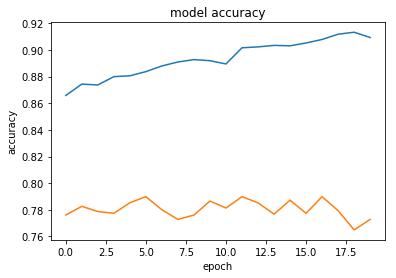

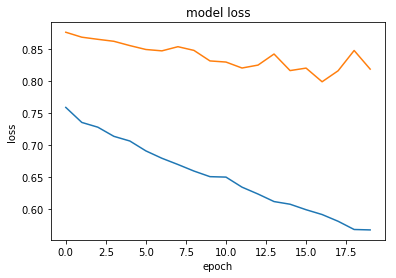

In [106]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [105]:
from sklearn.metrics import accuracy_score
y_test_predicted = model_rnn.predict(X_test)
y_test_predicted = np.where(y_test_predicted >= 0.5, 1, y_test_predicted)
y_test_predicted = np.where(y_test_predicted < 0.5, 0, y_test_predicted)
accuracy = accuracy_score(y_test, y_test_predicted)
print('Accuracy is: '+ str(100*accuracy)+'%')

Accuracy is: 77.28168089297439%
